# Previsão da velocidade do vento com LSTM

### **Objetivos**

O objetivo deste notebook é desenvolver um modelo de previsão de velocidade de  ventos utilizando Redes Neurais Artificiais (RNA), através de dados históricos das velocidades.

A partir desse modelo será feita dois tipos de análises:

1.   Utilizando hora(s) passada(s) para prever hora(s) à frente;
2.   Utilizando uma hora de determinado número de dias para prever esta mesma hora de dia à frente.

Para realizar a proposta foi utilizada a biblioteca ***TensorFlow*** que é uma plataforma completa de código aberto para *machine learning*, e foi usada para a criação e treinamento das redes neurais. Para isso o ***TensorFlow*** utiliza um API chamada ***Keras***. Por fim, foi utilizada uma rede neural recorrente, a ***LSTM*** (*Long Short Term Memory*), que é capaz de representar melhor o caráter sequencial das séries temporais, onde cada uma das observações está correlacionada.

### **Bibliotecas Utilizadas**

In [23]:
# Bibliotecas Utilizadas

from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

# Configuração das Figuras
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['font.size'] = 16

### **Leitura de Dados**

Leitura da planilha do histórico através do pandas, fornecendo o caminho no drive.


In [24]:
# Leitura
path_w = 'wind_data.xlsx'
wind = pd.read_excel(path_w)

# Parâmetros Básicos
horas = wind.shape[0]      # Número de horas
dias = wind.shape[1] - 1   # Número de dias

# Imprime DataFrame
wind['hora'] = wind['hora'].values + 1
wind

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,hora,dia 1,dia 2,dia 3,dia 4,dia 5,dia 6,dia 7,dia 8,dia 9,dia 10,dia 11,dia 12,dia 13,dia 14,dia 15,dia 16,dia 17,dia 18,dia 19,dia 20,dia 21,dia 22,dia 23,dia 24,dia 25,dia 26,dia 27,dia 28
0,1,6.176000,5.925500,7.714333,2.290167,4.236500,7.198000,4.854333,3.345667,4.718500,2.382333,6.761667,5.227000,6.128500,2.924333,5.401667,3.611667,2.591833,5.881833,6.079000,7.951667,6.897333,3.998500,3.225333,4.186833,5.043500,3.117500,4.235667,2.963000
1,2,7.759000,7.119833,6.939833,4.989667,5.196667,7.430667,5.809667,4.671167,2.082500,2.408500,6.421833,6.346500,5.873000,3.999333,6.035000,5.752333,5.062000,6.673167,10.056667,8.103333,7.523333,5.223833,2.550000,6.947667,4.337167,4.180667,3.409333,2.234500
2,3,7.347167,8.172500,4.911333,6.057667,6.708167,7.421000,8.520000,3.217667,2.153667,3.041000,4.996500,6.330833,5.227500,5.753000,5.567833,5.889167,6.361833,6.220167,10.023333,8.118333,7.567000,5.399833,4.459500,8.758333,4.254000,3.001167,2.791500,4.265667
3,4,6.771000,6.537667,5.566500,5.716333,5.504667,6.651167,8.227333,3.783167,4.339333,1.663000,4.066833,5.274500,4.746500,4.645500,6.246333,7.011667,5.670667,5.060167,8.017500,7.453333,6.355833,5.477500,5.842333,6.311333,3.644000,1.533333,3.356833,3.192833
4,5,6.065500,5.078500,6.466333,6.844833,5.737333,6.722333,6.053500,3.642333,3.401000,2.374833,5.812667,5.763667,4.165000,4.722333,5.152000,5.220667,5.795333,7.184000,6.375000,6.918667,6.798333,6.268500,5.468500,4.826167,3.347000,1.796667,2.517000,3.762667
5,6,6.966167,3.729500,5.084833,7.131167,7.166833,5.935000,4.813167,3.325500,3.894000,1.849500,4.499167,5.435667,4.864167,5.445833,6.650667,4.757333,5.663167,5.896167,4.915167,7.075333,5.448167,5.406667,6.198500,4.934333,3.444000,2.186667,2.860167,4.760833
6,7,6.743667,4.885333,4.914833,7.219167,6.917333,5.604000,4.606833,4.116333,4.213500,3.897500,4.423667,4.669500,4.748833,5.336833,6.258833,4.674000,4.390500,4.246500,3.069333,5.440000,5.157333,5.284167,5.520167,3.522833,3.243167,2.361500,3.501833,3.562667
7,8,6.873167,5.422167,6.538667,6.107167,5.788333,4.646500,4.099500,4.208167,3.575667,4.981333,3.584000,4.753833,4.995167,4.221500,4.959333,5.092333,4.727000,3.769000,3.851333,4.205500,5.220167,5.989167,4.750000,4.029000,2.662667,1.951333,3.697167,2.911833
8,9,5.750000,5.458500,6.811167,4.266000,4.160000,4.441500,4.089500,4.073667,3.935167,2.394333,3.028500,4.280667,4.145833,4.583833,4.155167,5.569667,4.154000,4.781407,3.882500,4.754333,4.796333,5.915000,4.580333,4.337500,3.114833,1.710333,4.541667,2.620500
9,10,4.921167,4.716000,6.453833,4.043500,4.260000,3.971667,3.998833,3.599833,1.487167,4.907500,3.207333,3.228833,4.065500,4.797167,4.043667,5.231417,3.508667,4.992000,3.678333,6.104833,4.068500,5.235500,4.683000,4.851667,2.999833,2.426667,3.666500,3.329833


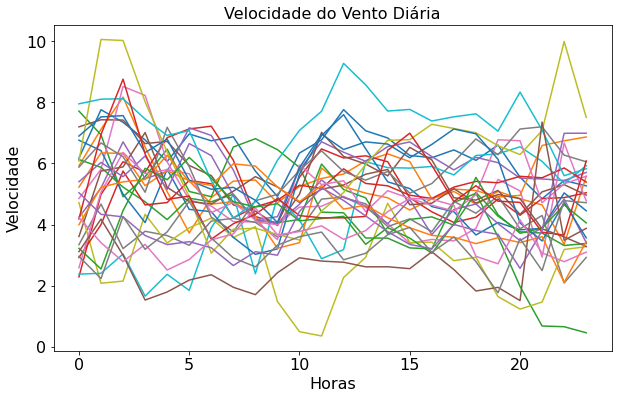

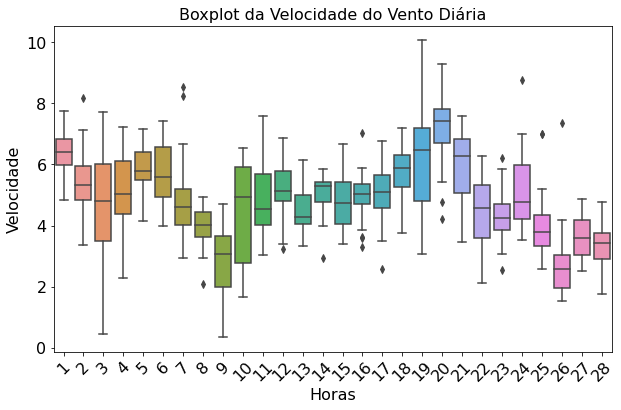

In [25]:
# Plota Dados
x_h = np.arange(0, horas)
for d in range(dias):
  plt.plot(x_h, wind[wind.columns[d+1]].values)
titulo = 'Velocidade do Vento Diária'
plt.title(titulo, fontsize=16)
plt.xlabel('Horas', fontsize=16)
plt.ylabel('Velocidade', fontsize=16)
plt.show()

columns = wind.columns
plt.figure()
sns.boxplot(data=wind.loc[:, wind.columns != 'hora'])
plt.xticks(np.arange(0, dias), np.arange(1, dias + 1), rotation=45)
plt.title('Boxplot da Velocidade do Vento Diária', fontsize=16)
plt.xlabel('Horas', fontsize=16)
plt.ylabel('Velocidade', fontsize=16)
plt.show()

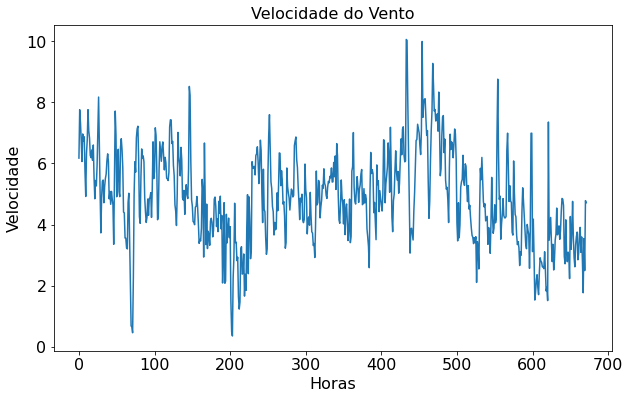

In [26]:
# Transforma dados para forma sequencial

def sequential_wind(wind):

  wind_seq = []
  for d in range(dias):
    for h in range(horas):
      w_seq = wind[wind.columns[d+1]].values[h]
      wind_seq.append(w_seq)

  # Transforma pra array
  wind_seq = np.asarray(wind_seq)

  return wind_seq

# Plota Dados Sequenciais
wind_seq = sequential_wind(wind)

x_hd = np.arange(0, horas*dias)
plt.plot(x_hd, wind_seq)
titulo = 'Velocidade do Vento'
plt.title(titulo, fontsize=16)
plt.xlabel('Horas', fontsize=16)
plt.ylabel('Velocidade', fontsize=16)
plt.show()

### **Tratamento dos Dados - Remover Outliers**

Uma das ferramentas estatísticas de tratamento dados é a remoção de outliers através da Amplitude Interquartil (IQR). O IQR foi desenvolvido no âmbito da estatística a fim de avaliar o grau de espalhamento de dados (dispersão) em torno da medida de centralidade. Há dois quartis de interesse, o primeiro quartil (inferior) e o terceiro quartil(superior), os quais podem ser calculados pelo pandas, através do método 'quantile', com input de 0.25 e 0.75, respectivamente.

A Figura abaixo, mostra a dispersão dos dados em uma distribuição normal, onde considera-se outlier qualquer dado fora do intervalo definido em vermelho.

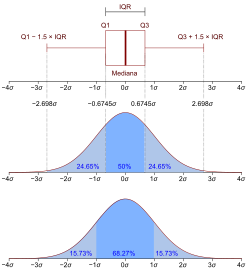


Portanto, esse tratamento foi aplicado para cada hora do histórico, observando suas grandezas estatísticas, sendo assim, caso o valor daquela hora viole algum dos limites, seu valor é substituído pelo respectivo limite. Como mostrado no Boxplot do histórico, em diversas horas há outliers, os quais serão removidos pelo tratamento dos dados.

In [27]:
def check_outliers(wind_dia, dia):
  
  # Calcula Quartil inferior e superior, respectivamente
  Q1, Q3 = wind_dia.quantile(0.25), wind_dia.quantile(0.75)
  IQR = Q3 - Q1

  lim_sup = Q3 + 1.5*IQR
  lim_inf = Q1 - 1.5*IQR

  wind_new_values = []

  for hr in range(24):
    hora = hr + 1
    wind_hr = wind_dia.values[hr]
    if wind_hr > lim_sup:
      print('Remove Outlier Superior - Hora %i do Dia %i' % (hora, dia))
      wind_new_values.append(lim_sup)

    if wind_hr < lim_inf:
      print('Remove Outlier Inferior - Hora %i do Dia %i' % (hora, dia))
      wind_new_values.append(lim_inf)

    if lim_inf <= wind_hr <= lim_sup:
      wind_new_values.append(wind_hr)
    
  return wind_new_values

for dia in range(dias):
  dia_atual = dia + 1
  txt = 'dia ' + str(dia_atual)
  wind_dia = wind[txt]
  wind_dia_outlier = check_outliers(wind_dia=wind_dia, dia=dia_atual)
  wind[txt] = wind_dia_outlier

wind_seq = sequential_wind(wind)

Remove Outlier Superior - Hora 3 do Dia 2
Remove Outlier Superior - Hora 3 do Dia 7
Remove Outlier Superior - Hora 4 do Dia 7
Remove Outlier Inferior - Hora 23 do Dia 8
Remove Outlier Inferior - Hora 10 do Dia 12
Remove Outlier Inferior - Hora 1 do Dia 14
Remove Outlier Inferior - Hora 1 do Dia 16
Remove Outlier Superior - Hora 4 do Dia 16
Remove Outlier Inferior - Hora 23 do Dia 16
Remove Outlier Inferior - Hora 24 do Dia 16
Remove Outlier Inferior - Hora 1 do Dia 17
Remove Outlier Inferior - Hora 8 do Dia 20
Remove Outlier Inferior - Hora 9 do Dia 20
Remove Outlier Inferior - Hora 2 do Dia 23
Remove Outlier Superior - Hora 6 do Dia 23
Remove Outlier Superior - Hora 3 do Dia 24
Remove Outlier Superior - Hora 23 do Dia 25
Remove Outlier Superior - Hora 24 do Dia 25
Remove Outlier Superior - Hora 22 do Dia 26


## **Análise I - LSTM com Histórico Completo**

### **Definição de Treino e Teste**

Nessa etapa, os o histórico de velocidade do vento são separados em treino e teste. Primeiramente, os dados são padronizados pelo 'StandardScaler', o qual transforma os dados de maneira que tenha média como 0 e desvio padrão como 1, padronizando os dados. Em seguida, 70% do histórico é definido como treino e o restante como teste. Por fim, é apresentado o gráfico do histórico com a separação.


(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]), <a list of 10 Text major ticklabel objects>)

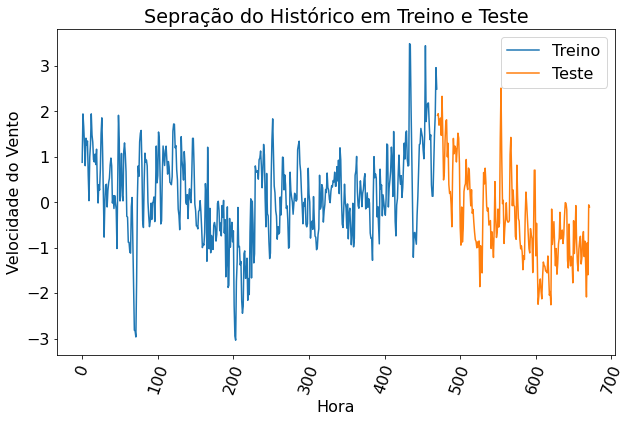

In [28]:
# Padronização dos Dados para LSTM #

sc = StandardScaler()
sc.fit(wind_seq.reshape(-1,1))
y = sc.transform(wind_seq.reshape(-1,1))

# Dividir entre treino e teste #

Historico = wind_seq

train_percent = 0.70
tamanho_treino = int(len(Historico)*train_percent) # Selecionando dados para treino
tamanho_teste = len(Historico) - tamanho_treino    # Restante dos valores são usados para teste

ytreino = y[0:tamanho_treino]
yteste = y[tamanho_treino:len(Historico)]

vetor = np.arange(len(y))
sns.lineplot(x=vetor[0:len(ytreino)], y=ytreino[:,0], label='Treino') 
sns.lineplot(x=vetor[len(ytreino):len(vetor)], y=yteste[:,0], label='Teste')
plt.title('Sepração do Histórico em Treino e Teste')
plt.xlabel('Hora')
plt.ylabel('Velocidade do Vento')
plt.xticks(rotation=70)

Agora, os dados de treino e teste são organizados de forma a serem aplicados na LSTM. A informação mais importante nessa etapa é o 'n_passos', o qual representa o número de dados passados que são usados para prever o próximo. Dessa forma, a função 'separa_dados' cria os vetores de entrada e saída para treino e teste.

In [29]:
# Função para separar os dados

## Entrada -> vetor: velocidade do vento
#                    n_passos: número de passos no regressor
## Saída ->
#              X_novo: Array 2D 
#              y_novo: Array 1D - Nosso alvo

def separa_dados(vetor, n_passos):
    X_novo, y_novo = [], []
    for i in range(n_passos,vetor.shape[0]):
        X_novo.append(list(vetor.loc[i-n_passos:i-1]))
        y_novo.append(vetor.loc[i])

    X_novo, y_novo = np.array(X_novo), np.array(y_novo) 
    return X_novo, y_novo

npassos = 2
vetor = pd.DataFrame(ytreino)[0]
xtreino_novo, ytreino_novo = separa_dados(vetor, npassos)

vetor2 = pd.DataFrame(yteste)[0]
xteste_novo, yteste_novo = separa_dados(vetor2, npassos)

### **Treinamento da Rede Neural (LSTM)**

Agora, a rede neural é criada, adiciona-se uma LSTM com função de ativação 'relu'. Além disso adiciona-se camadas densas. O método 'compile' compila a rede neural, com a métrica do erro médio quadrático e otimizador 'adam'.

In [30]:
## O que a LSTM espera:
# A entrada de redes recorrentes deve possuir a seguinte forma para a entrada: 
# (número de amostras, número de passos no tempo, e número de atributos por passo no tempo)
# A glorot_uniform é a inicialização utilizada por padrão no Keras e é uma boa opção de inicialização dos pesos.

xtreino_novo = xtreino_novo.reshape((xtreino_novo.shape[0], xtreino_novo.shape[1], 1))
xteste_novo = xteste_novo.reshape((xteste_novo.shape[0], xteste_novo.shape[1], 1))

recorrente = Sequential(name='Wind_Forecast')
recorrente.add(LSTM(30, input_shape=(xtreino_novo.shape[1], xtreino_novo.shape[2]), activation='relu', return_sequences=True))
recorrente.add(LSTM(20, return_sequences=True))
recorrente.add(LSTM(10))
recorrente.add(Dense(units=1))
recorrente.add(Dense(units=1))
recorrente.compile(loss='mean_squared_error', optimizer='adam')
recorrente.summary()

Model: "Wind_Forecast"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 2, 30)             3840      
_________________________________________________________________
lstm_7 (LSTM)                (None, 2, 20)             4080      
_________________________________________________________________
lstm_8 (LSTM)                (None, 10)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 9,173
Trainable params: 9,173
Non-trainable params: 0
_________________________________________________________________


O método 'fit' ajusta a rede recebendo como entrada os dados de treino e teste, número épocas e parâmetros adicionais. Em seguida, é feita a previsão dos os dados de entrada para teste e o resultado é comparado com os valores reais do histórico. Para avaliar a rede neural, foram aplicadas as seguintes métricas:



* Mean Squared Error
* Root Mean Squared Error
* Mean Absolute Error
* Mean Absolute Percentage Error
* U2 of Theil
* Correlation



In [31]:
# Aplica função FIT para o treino da rede neural

resultado = recorrente.fit(xtreino_novo, ytreino_novo, 
                           validation_data=(xteste_novo, yteste_novo), epochs=50, verbose=0, shuffle=False)

Mean Squared Error: 0.76
Root Mean Squared Error: 0.87
Mean Absolute Error: 0.67
Mean Absolute Percentage Error: 18.09 %
U2 of Theil: 0.89
Correlation: 0.81


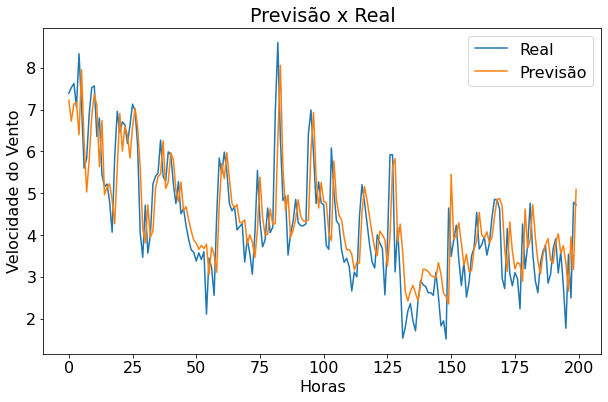

In [32]:
# Previsão
y_predito = recorrente.predict(xteste_novo)

teste = sc.inverse_transform(yteste[:, 0])
previsao = sc.inverse_transform(y_predito[:, 0])

plt.figure()
plt.plot(teste[npassos:len(teste)], label='Real')
plt.plot(previsao, label='Previsão')
plt.xlabel('Horas')
plt.ylabel('Velocidade do Vento')
plt.title('Previsão x Real')
plt.legend()

def metrics_calculation(y_true, y_pred):

  # Cacula MSE, RMSE e MAE

  mse = mean_squared_error(teste[npassos:len(teste)], previsao, squared=True)
  rmse = mean_squared_error(teste[npassos:len(teste)], previsao, squared=False)
  mae = mean_absolute_error(teste[npassos:len(teste)], previsao)

  # Define Funções para Calcular U2 de Theil

  def division(measure, previousI):
    return measure / previousI

  def power(measure):
    return np.power(measure, 2)

  def summation(measure):
    return np.sum(measure)

  def mean(N, measure):
    return (1/N) * measure

  def sqrt(measure):
    return np.sqrt(measure)

  def computeTheilU2(y_true, y_pred):
      N = len(y_true)
      
      subtractionNumerator = y_pred[1:] - y_true[1:]
      divisionNumerator = division(subtractionNumerator, y_true[:-1])
      powerNumerator = power(divisionNumerator)
      summationNumerator = summation(powerNumerator)
      meanNumerator = mean(N, summationNumerator)
      numerator = sqrt(meanNumerator)
      
      subtractionDenominator = y_true[1:] - y_true[:-1]
      powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
      denominator = sqrt(mean(N, summation(powerDenominator)))
          
      theilU2 = numerator / denominator
      
      return theilU2
    
  theilU2 = computeTheilU2(y_true=y_true, y_pred=y_pred)

  # Função para MAPE
  def computeMAPE(Y_actual,Y_Predicted):
      mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100

      return mape

  mape = computeMAPE(Y_actual=y_true, Y_Predicted=y_pred)

  return mse, rmse, mae, mape, theilU2

y_true = teste[npassos:len(teste)]
y_pred = previsao

mse, rmse, mae, mape, theilU2 = metrics_calculation(y_true=y_true, y_pred=y_pred)
corr = np.corrcoef(y_true, y_pred)
# Prints
print('Mean Squared Error: %4.2f' % mse)
print('Root Mean Squared Error: %4.2f' % rmse)
print('Mean Absolute Error: %4.2f' % mae)
print('Mean Absolute Percentage Error: %4.2f %%' % mape)
print('U2 of Theil: %4.2f' % theilU2)
print('Correlation: %4.2f' % corr[0, 1])

Através das métricas, foram obtidos resultados satisfatórios, além disso, a estatística de Theil apresenta valor menor que 1, o que indica que a previsão possui desempenho melhor que um *naive guess* (é aquele que não usa sofisticação para fazer uma previsão, normalmente fazendo uma previsão aleatória ou constante. Esses modelos não usam nenhum conhecimento sobre o domínio ou qualquer aprendizado para fazer uma previsão). Outro bom indicativi é correlação, a qual atingiu um valor positivo próximo de 1, o que indica 

O gráfico da comparação Real x Previsão mostra que os dados previstos acompanham as variações dos dados reais, comprovado pela correlação, entretanto, possuem um atraso, o que afetou a qualidade da previsão.

Text(0, 0.5, 'Custo')

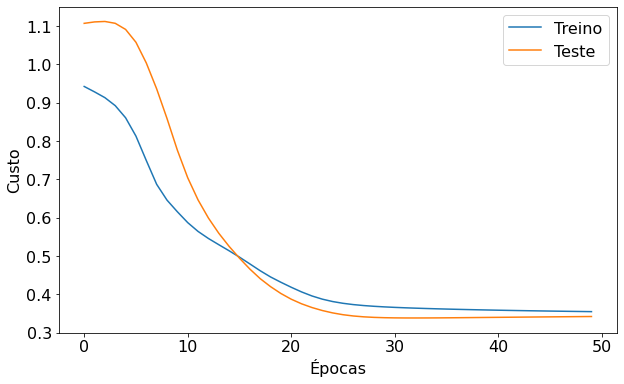

In [33]:
plt.plot(resultado.history['loss'])
plt.plot(resultado.history['val_loss'])
plt.legend(['Treino','Teste'])
plt.xlabel('Épocas')
plt.ylabel('Custo')

Por fim, o gráfico acima mostra o número de épocas em função da métrica de simualação da rede neural. Pode-se observar que não háá ganho ao utilizar mais que 50 épocas.

## **Análise II - LSTM Diária**

In [34]:
hora = 20
df_hora = wind.loc[wind['hora'] == hora]
columns = df_hora.columns

wind_seq_hora = []
for d in range(dias):
  column = columns[d + 1]
  current_wind = df_hora[column].values
  wind_seq_hora.append(current_wind)

wind_seq_hora = np.asarray(wind_seq_hora)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30.]),
 <a list of 8 Text major ticklabel objects>)

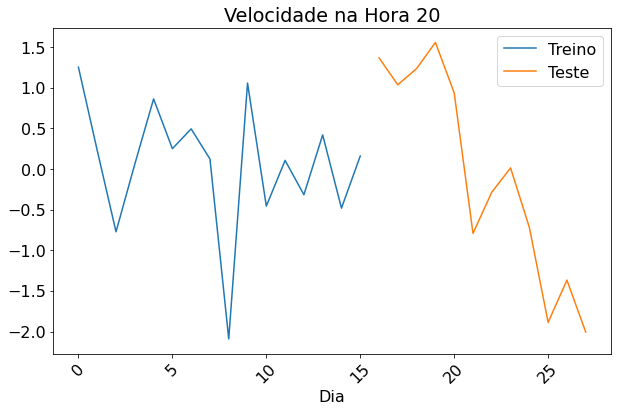

In [35]:
# Padronização dos Dados para LSTM #

sc = StandardScaler()
sc.fit(wind_seq_hora.reshape(-1,1))
y = sc.transform(wind_seq_hora.reshape(-1,1))

# Dividir entre treino e teste #

Historico = wind_seq_hora

train_percent = 0.60
tamanho_treino = int(len(Historico)*train_percent) # Selecionando dados para treino
tamanho_teste = len(Historico) - tamanho_treino    # Restante dos valores são usados para teste

ytreino = y[0:tamanho_treino]
yteste = y[tamanho_treino:len(Historico)]

vetor = np.arange(len(y))
sns.lineplot(x=vetor[0:len(ytreino)], y=ytreino[:,0], label='Treino') 
sns.lineplot(x=vetor[len(ytreino):len(vetor)], y=yteste[:,0], label='Teste')
plt.title('Velocidade na Hora %i' % hora)
plt.xlabel('Dia')
plt.xticks(rotation=45)

In [36]:
npassos = 2
vetor = pd.DataFrame(ytreino)[0]
xtreino_novo, ytreino_novo = separa_dados(vetor, npassos)

vetor2 = pd.DataFrame(yteste)[0]
xteste_novo, yteste_novo = separa_dados(vetor2, npassos)

### **Treinamento da Rede Neural (LSTM)**

In [37]:
## O que a LSTM espera
# A entrada de redes recorrentes deve possuir a seguinte forma para a entrada: 
# (número de amostras, número de passos no tempo, e número de atributos por passo no tempo)
# A glorot_uniform é a inicialização utilizada por padrão no Keras e é uma boa opção de inicialização dos pesos.

xtreino_novo = xtreino_novo.reshape((xtreino_novo.shape[0], xtreino_novo.shape[1], 1))
xteste_novo = xteste_novo.reshape((xteste_novo.shape[0], xteste_novo.shape[1], 1))

recorrente = Sequential(name='Wind_Forecast')
recorrente.add(LSTM(30, input_shape=(xtreino_novo.shape[1], xtreino_novo.shape[2]), activation='relu', return_sequences=True))
recorrente.add(LSTM(20, return_sequences=True))
recorrente.add(LSTM(10))
recorrente.add(Dense(units=1))
recorrente.add(Dense(units=1))
recorrente.compile(loss='mean_squared_error', optimizer='adam')
recorrente.summary()

Model: "Wind_Forecast"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 2, 30)             3840      
_________________________________________________________________
lstm_10 (LSTM)               (None, 2, 20)             4080      
_________________________________________________________________
lstm_11 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 9,173
Trainable params: 9,173
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Aplica função FIT para o treino da rede neural

resultado = recorrente.fit(xtreino_novo, ytreino_novo, 
                           validation_data=(xteste_novo, yteste_novo), epochs=1000, verbose=0, shuffle=False)

Mean Squared Error: 10.03
Root Mean Squared Error: 3.17
Mean Absolute Error: 2.51
Mean Absolute Percentage Error: 94.76 %
U2 of Theil: 4.19


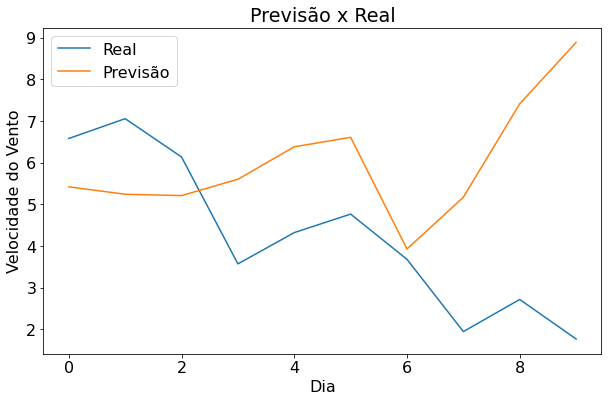

In [39]:
# Previsão
y_predito = recorrente.predict(xteste_novo)

teste = sc.inverse_transform(yteste[:, 0])
previsao = sc.inverse_transform(y_predito[:, 0])

plt.figure()
plt.plot(teste[npassos:len(teste)], label='Real')
plt.plot(previsao, label='Previsão')
plt.xlabel('Dia')
plt.ylabel('Velocidade do Vento')
plt.title('Previsão x Real')
plt.legend()

# Metrics
y_true = teste[npassos:len(teste)]
y_pred = previsao

mse, rmse, mae, mape, theilU2 = metrics_calculation(y_true=y_true, y_pred=y_pred)

# Prints
print('Mean Squared Error: %4.2f' % mse)
print('Root Mean Squared Error: %4.2f' % rmse)
print('Mean Absolute Error: %4.2f' % mae)
print('Mean Absolute Percentage Error: %4.2f %%' % mape)
print('U2 of Theil: %4.2f' % theilU2)